# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
from datetime import datetime
import multiprocessing as mp
import pandas as pd
import numpy as np
import scipy
import sklearn.preprocessing
import sklearn.metrics
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool


s3 bucket: `s3-student-mle-20240325-3ac233b55a`

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

# Обзор данных
Проверяем данные, есть ли с ними явные проблемы.

In [3]:
display(tracks.sample(5))
tracks.dtypes

,track_id,albums,artists,genres
72023,656472,"[70753, 1834848]",[3968],[35]
434436,30109520,[3637418],[3881178],"[2, 102]"
25769,168725,"[16736, 16737, 1001793]",[64419],"[47, 158]"
236558,13918567,[1514126],[352942],"[3, 75]"
381451,25695492,[3037711],[426177],[68]


track_id     int64
albums      object
artists     object
genres      object
dtype: object

In [4]:
display(catalog_names.sample(5))
display(catalog_names.dtypes)
catalog_names.type.value_counts()

,id,type,name
548955,13082415,album,Кисло-Сладкий & Bonah
494235,10886271,album,God of Sick Dreams
489625,10700992,album,Yoga Fitness Music Playlist
1609189,62242635,track,Беспризорник
1806913,97836149,track,Paradisus-Paradoxum


id       int64
type    object
name    object
dtype: object

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [5]:
catalog_names.type = catalog_names.type.astype('category')
catalog_names.dtypes

id         int64
type    category
name      object
dtype: object

In [6]:
display(interactions.sample(5))
interactions.dtypes

,user_id,track_id,track_seq,started_at
22,882752,178624,23,2022-07-15
82,1156452,83675201,83,2022-11-15
14,331154,59673,15,2022-02-12
5,547265,783272,6,2022-10-09
4246,818232,43505841,4247,2022-11-07


user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

In [7]:
# все трэки есть в catalog_names
tracks.track_id.isin(catalog_names[catalog_names.type=='track'].id).nunique()

1

Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

In [8]:
%%time
albums = catalog_names[catalog_names.type=='album']
albums_ids = np.array(albums.id.values.tolist())
def check_albums(track_items):
    return True in [item_id in albums_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['albums_ok'] = pool.map(check_albums, tracks.albums)
tracks.albums_ok.value_counts()

CPU times: user 3.03 s, sys: 1.79 s, total: 4.82 s
Wall time: 38.8 s


albums_ok
True     999982
False        18
Name: count, dtype: int64

In [9]:
%%time
genres = catalog_names[catalog_names.type=='genre']
genres_ids = np.array(genres.id.values.tolist())
def check_genres(track_items):
    return True in [item_id in genres_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['genres_ok'] = pool.map(check_genres, tracks.genres)
tracks.genres_ok.value_counts()

CPU times: user 1.9 s, sys: 1.6 s, total: 3.5 s
Wall time: 4.2 s


genres_ok
True     996306
False      3694
Name: count, dtype: int64

In [10]:
%%time
artists = catalog_names[catalog_names.type=='artist']
artists_ids = np.array(artists.id.values.tolist())
def check_artists(track_items):
    return True in [item_id in artists_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['artists_ok'] = pool.map(check_artists, tracks.artists)
tracks.artists_ok.value_counts()

CPU times: user 2.15 s, sys: 2.14 s, total: 4.29 s
Wall time: 5.12 s


artists_ok
True     984631
False     15369
Name: count, dtype: int64

In [11]:
%%time
# Удаление
tracks = tracks.query("artists_ok==True and albums_ok==True and genres_ok==True")
interactions = interactions[interactions.track_id.isin(tracks.track_id)]

CPU times: user 4 s, sys: 635 ms, total: 4.63 s
Wall time: 4.63 s


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

В catalog_names поле type было преобразовано в категорию;
Найдено 18 трэков у которых ни один из альбомов не присутствует в catalog_names;
Найдено 3694 трэка у которых ни один из жанров не присутствует в catalog_names;
Найдено 15369 трэков у которых ни один из артистов не присутствует в catalog_names;

Удалять их необязательно?

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

array([[<Axes: title={'center': 'track_id'}>]], dtype=object)

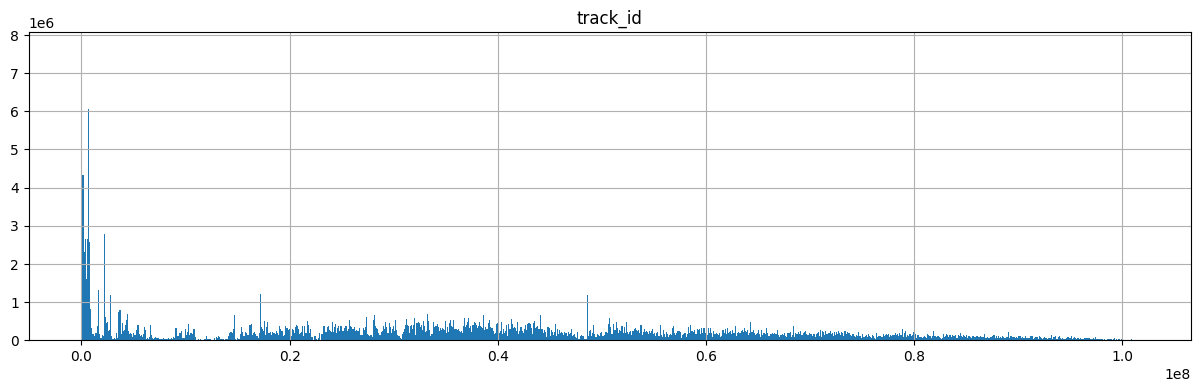

In [12]:
interactions.hist(column='track_id', bins=1000, figsize=(15,4))

In [13]:
top100tracks = tracks[tracks.track_id.isin(interactions.track_id.value_counts()[:100].index)]

Наиболее популярные треки

In [14]:
tracks_catalog = catalog_names[catalog_names.type=='track']
top100tracks_catalog = tracks_catalog[tracks_catalog.id.isin(top100tracks.track_id)]
top100tracks_catalog = top100tracks_catalog.rename({'id': 'track_id'}, axis=1)
def get_list(df, ids):
    return ', '.join(df[df.id.isin(ids)].name)
top100tracks['artists_names'] = top100tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
top100tracks['genres_names'] = top100tracks.apply(lambda row: get_list(genres, row.genres), axis=1)
top100tracks.merge(top100tracks_catalog, on='track_id')[['track_id', 'artists_names', 'name', 'genres_names']]

/tmp/ipykernel_404172/3775954581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100tracks['artists_names'] = top100tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
/tmp/ipykernel_404172/3775954581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100tracks['genres_names'] = top100tracks.apply(lambda row: get_list(genres, row.genres), axis=1)


,track_id,artists_names,name,genres_names
0,10216,Scorpions,Wind Of Change,"hardrock, allrock"
1,37384,The Cranberries,Zombie,"rock, allrock"
2,48951,Bon Jovi,It's My Life,"rock, hardrock, allrock"
3,52100,No Doubt,Don't Speak,pop
4,53404,Nirvana,Smells Like Teen Spirit,"alternative, rock, allrock"
...,...,...,...,...
95,78426489,Minelli,Rampampam,dance
96,81848875,Galibri & Mavik,Федерико Феллини,"pop, ruspop"
97,83063895,HammAli & Navai,Птичка,"pop, ruspop"
98,84382282,"Markul, Джарахов",Я в моменте,"rusrap, rap"


Наиболее популярные жанры

In [15]:
# cм выше

Треки, которые никто не прослушал

In [16]:
tracks[~tracks.track_id.isin(interactions.track_id)]
# таких нет

,track_id,albums,artists,genres,albums_ok,genres_ok,artists_ok


In [17]:
interactions.groupby(['user_id', 'track_id'])['track_seq'].count().nunique()

1

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [18]:
tracks_catalog = tracks_catalog.rename({'id': 'track_id'}, axis=1)

In [19]:
tracks.merge(tracks_catalog, on='track_id')

,track_id,albums,artists,genres,albums_ok,genres_ok,artists_ok,type,name
0,26,"[3, 2490753]",[16],"[11, 21]",True,True,True,track,Complimentary Me
1,38,"[3, 2490753]",[16],"[11, 21]",True,True,True,track,Momma's Boy
2,135,"[12, 214, 2490809]",[84],[11],True,True,True,track,Atticus
3,136,"[12, 214, 2490809]",[84],[11],True,True,True,track,24 Hours
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],True,True,True,track,Don't Upset The Rhythm (Go Baby Go)
...,...,...,...,...,...,...,...,...,...
980965,101478482,[21399811],[5540395],"[3, 75]",True,True,True,track,На лицо
980966,101490148,[21403052],[9078726],"[11, 20]",True,True,True,track,Без капли мысли
980967,101493057,[21403883],[11865715],"[44, 75]",True,True,True,track,SKITTLES
980968,101495927,[21404975],[4462686],"[3, 75]",True,True,True,track,Москва


In [20]:
%%time
# tracks['artists_names'] = tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
# tracks['genres_names'] = tracks.apply(lambda row: get_list(genres, row.genres), axis=1)
def apply_artists(artists_id):
    return  get_list(artists, artists_id)
def apply_genres(genres_id):
    return get_list(genres, genres_id)
with mp.Pool(mp.cpu_count()) as pool:
    tracks['artists_names'] = pool.map(apply_artists, tracks.artists)
    tracks['genres_names'] = pool.map(apply_genres, tracks.genres)
items = tracks.merge(tracks_catalog, on='track_id')

CPU times: user 6.24 s, sys: 1.63 s, total: 7.86 s
Wall time: 47.4 s


In [21]:
items = items.drop(['albums_ok', 'genres_ok', 'artists_ok', 'type'], axis=1)

In [22]:
items.sample(5)

,track_id,albums,artists,genres,artists_names,genres_names,name
807164,64440710,[7896506],[6987644],"[3, 75]",ВНЕМОЙ,"rusrap, rap",4EVER
463545,32423255,[3950994],[3673697],[11],Регина Тодоренко,pop,Ты мне нужен
486410,33754070,"[4130032, 4179021]",[798473],"[38, 47]",X Japan,"classicmetal, metal",Forever Love
793775,63079152,[10005053],"[698658, 8089135]",[16],"Oğuzhan, Alican Sandık",dance,Stay
587570,40826705,[5320162],"[3454418, 3606849]","[44, 75]","Post Malone, Swae Lee","foreignrap, rap",Spoil My Night


In [23]:
%%time
interactions.started_at = interactions.started_at.apply(lambda ts: ts.date())

CPU times: user 2min, sys: 7.47 s, total: 2min 7s
Wall time: 2min 7s


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [24]:
genres.to_parquet('genres.parquet')
artists.to_parquet('artists.parquet')
albums.to_parquet('albums.parquet')
events = interactions
events.to_parquet('events.parquet')
items.to_parquet('items.parquet')
top100tracks.to_parquet('top100.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Если есть желание можно перезапустить ядро, затем раскомментировать и выполнить ячейку ниже

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [25]:
# from datetime import datetime
# import multiprocessing as mp
# import pandas as pd
# import numpy as np
# import scipy
# import sklearn.preprocessing
# import sklearn.metrics
# from implicit.als import AlternatingLeastSquares
# from catboost import CatBoostClassifier, Pool
#
# genres = pd.read_parquet('genres.parquet')
# artists = pd.read_parquet('artists.parquet')
# albums = pd.read_parquet('albums.parquet')
# events = pd.read_parquet('events.parquet')
# items = pd.read_parquet('items.parquet')

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [26]:
train_test_global_time_split_date = pd.to_datetime('2022-12-16').date()  # this will not work with cudf
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# пользователи в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# пользователи, которые есть и в train и в test
common_users = set(users_train) & set(users_test)  # this will not work with cudf
print(len(users_train), len(users_test), len(common_users))

1342107 782025 751365


In [27]:
cold_users = set(users_test) - common_users
print(len(cold_users))

30660


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [28]:
item_popularity = events_train.groupby(["track_id"]).agg(users=("user_id", "nunique")).reset_index().sort_values(by='users', ascending=False)
top_popular = item_popularity[:100]
top_popular.to_parquet('top_popular.parquet')
item_popularity.head(10)

In [29]:
cold_users_events = events_test[events_test.user_id.isin(cold_users)]
len(set(cold_users_events[cold_users_events.track_id.isin(top_popular.track_id)].track_id) & set(top_popular.track_id))

100

# Персональные

Рассчитаем персональные рекомендации.

In [30]:
%%time
# перекодирование идентификаторов пользователей:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events["user_id_enc"] = user_encoder.transform(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
# перекодирование идентификаторов трэков:
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
events_test["track_id_enc"] =  item_encoder.transform(events_test["track_id"])

<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 1min 22s, sys: 742 ms, total: 1min 23s
Wall time: 1min 23s


<timed exec>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
# создание разряжённой матрицы формата CSR
user_item_matrix_train = scipy.sparse.csr_matrix((
    [1] * len(events_train),
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8)


In [32]:
%%time
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 28.8 s, sys: 386 ms, total: 29.2 s
Wall time: 29.3 s


In [33]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=False, n=10):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
        user_id_enc,
        user_item_matrix[user_id_enc],
        filter_already_liked_items=not include_seen,
        N=n)
    recommendations = pd.DataFrame({"track_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["track_id"] = item_encoder.inverse_transform(recommendations["track_id_enc"])

    return recommendations

user_id = events_train['user_id'].sample().iat[0]
user_id_enc = user_encoder.transform([user_id])[0]
print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("track_id"), on="track_id")
)
user_history_to_print = user_history[["track_id", "artists_names", "name", "genres_names", "started_at"]].tail(10)
display(user_history_to_print)

print("Рекомендации")
user_recommendations = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder)
user_recommendations = user_recommendations.merge(items[["track_id", "artists_names", "name", "genres_names", ]], on="track_id")
display(user_recommendations)

История (последние события, recent)


,track_id,artists_names,name,genres_names,started_at
412,44305804,The Score,The Fear,alternative,2022-12-13
413,44317468,Piotr Musiał,Frostpunk Theme,"videogame, soundtrack",2022-12-13
414,44317539,Piotr Musiał,The City Must Survive,"videogame, soundtrack",2022-12-14
415,44790565,"Jesse Scott, Shannon Jae Prior",The Usual,pop,2022-12-14
416,45087960,Ibrahim Maalouf,True Sorry,"jazz, conjazz",2022-12-14
417,45139110,Manu Chao,Bongo Bong,"folk, latinfolk",2022-12-14
418,45971728,Cosmo Sheldrake,Come Along,indie,2022-12-15
419,46560190,The Tech Thieves,Forget,electronics,2022-12-15
420,46922327,Our Last Night,Reality Without You,"alternative, posthardcore",2022-12-15
421,46922328,Our Last Night,Sunrise,"alternative, posthardcore",2022-12-15


Рекомендации


,track_id_enc,score,track_id,artists_names,name,genres_names
0,82891,0.453143,732401,Земфира,ИСКАЛА,"rusrock, allrock"
1,16819,0.439567,105324,КИНО,Звезда по имени Солнце,"rusrock, allrock"
2,121218,0.433434,2192826,Мумий Тролль,Владивосток 2000,"rusrock, allrock"
3,8547,0.400062,48951,Bon Jovi,It's My Life,"rock, hardrock, allrock"
4,10735,0.396801,65765,Amy Macdonald,This Is The Life,pop
5,196529,0.378272,6705392,The White Stripes,Seven Nation Army,alternative
6,18663,0.367459,109647,КИНО,Хочу перемен,"rusrock, allrock"
7,26638,0.364384,178529,Linkin Park,Numb,"numetal, metal"
8,138850,0.341636,2786721,Nickelback,When We Stand Together,"rock, allrock"
9,39344,0.337803,328683,Evanescence,Bring Me To Life,"alternative, rock, allrock"


In [34]:
%%time
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = events_train['user_id_enc'].unique()  # range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=False, N=100)


# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(),
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("personal_als.parquet")
max_als_score = max(als_recommendations.score)
print(max_als_score)
als_recommendations.sample(5)

3.762998104095459
CPU times: user 6min 36s, sys: 1min 34s, total: 8min 11s
Wall time: 8min 11s


,user_id,item_id,score
79675909,815931,50685843,0.038956
56087165,574399,65851540,0.170714
19745770,202152,49961817,0.058948
131419348,1345996,74611690,0.054312
2576729,26396,340904,0.004396


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [35]:
%%time
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_track_ids_enc = events_train['track_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_track_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_track_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_track_ids_enc,
    "sim_track_id_enc": sim_item_track_ids_enc.tolist(),
    "score": sim_item_scores.tolist()})

similar_items = similar_items.explode(["sim_track_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_track_id_enc"] = similar_items["sim_track_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_enc"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_enc"])
similar_items = similar_items.drop(columns=["track_id_enc", "sim_track_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("track_id_1 != track_id_2")

similar_items.to_parquet('similar.parquet')
similar_items.sample(5)

CPU times: user 22.8 s, sys: 774 ms, total: 23.6 s
Wall time: 23.7 s


,score,track_id_1,track_id_2
4816045,0.980098,35445997,36800728
1483126,0.804104,20858587,20432682
7889859,0.765436,662816,629249
3738937,0.999769,16320048,16320139
5161757,0.954698,27071448,3652657


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [36]:
%%time
def get_user_features(events):
    user_features = events.groupby('user_id').agg(
        tracks_total=('track_id', 'nunique'),
        hearing_days=('started_at', lambda x: (x.max() - x.min()).days),
    )
    user_features['tracks_per_day'] = user_features['tracks_total'] / user_features['hearing_days']
    return user_features

user_features_for_train = get_user_features(events_train)

CPU times: user 1min 12s, sys: 3.31 s, total: 1min 16s
Wall time: 1min 16s


In [37]:
events = events.rename(columns={'track_id': 'item_id'})
events_train = events_train.rename(columns={'track_id': 'item_id'})
events_test = events_test.rename(columns={'track_id': 'item_id'})

In [38]:
%%time
def get_item_features(events):
    items_features = events.groupby('item_id').agg(
        nusers=('user_id', 'nunique'),
    )
    return items_features

item_features_for_train = get_item_features(events_train)


CPU times: user 36.4 s, sys: 2.14 s, total: 38.5 s
Wall time: 38.6 s


In [39]:
# genre_names_to_id = genres.reset_index().set_index("name")["id"].to_dict()
# genre_names_to_id

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [40]:
split_date_for_labels = pd.to_datetime('2022-12-24').date()
split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()
events_labels.nunique()

user_id         697473
item_id         502028
track_seq        12850
started_at           8
user_id_enc     697473
track_id_enc    502028
dtype: int64

In [41]:
candidates = als_recommendations[["user_id", "item_id", "score"]]


In [42]:
%%time
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных

events_labels["target"] = 1

candidates = candidates.merge(events_labels[["user_id", "item_id", "target"]],
                              on=["user_id", "item_id"], how='left')

candidates["target"] = candidates["target"].fillna(0).astype("int")
#
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)
#
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates[candidates.target==1],
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
])
candidates_for_train.shape

CPU times: user 1min 22s, sys: 6.23 s, total: 1min 29s
Wall time: 1min 28s


<timed exec>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


(1167565, 4)

In [43]:
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")
candidates_for_train = candidates_for_train.merge(item_features_for_train, on="item_id", how="left")

In [44]:
candidates_for_train.sample(5)


,user_id,item_id,score,target,tracks_total,hearing_days,tracks_per_day,nusers
749685,633851,21709010,0.055507,0,15,89,0.168539,22939
249563,875138,34726523,0.041310,1,28,6,4.666667,25446
852834,816871,48592062,0.133691,0,190,229,0.829694,24241
686333,521309,19326805,0.097350,0,74,15,4.933333,22572
208326,728613,83063895,0.062785,1,24,157,0.152866,52469


In [45]:
%%time
# задаём имена колонок признаков и таргета
features = ['score',
            'tracks_total', 'hearing_days', 'tracks_per_day',
            'nusers']
target = 'target'

# создаём Pool
train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=True,
    random_seed=0,
    task_type='GPU'
)

# тренируем модель
cb_model.fit(train_data)



0:	learn: 0.6769972	total: 31.6ms	remaining: 31.6s
1:	learn: 0.6640559	total: 34.9ms	remaining: 17.4s
2:	learn: 0.6534858	total: 38.1ms	remaining: 12.7s
3:	learn: 0.6450476	total: 41.2ms	remaining: 10.3s
4:	learn: 0.6381866	total: 44.4ms	remaining: 8.84s
5:	learn: 0.6326253	total: 47.6ms	remaining: 7.88s
6:	learn: 0.6279043	total: 50.7ms	remaining: 7.19s
7:	learn: 0.6241681	total: 54ms	remaining: 6.7s
8:	learn: 0.6210241	total: 57.2ms	remaining: 6.3s
9:	learn: 0.6183554	total: 60.7ms	remaining: 6.01s
10:	learn: 0.6162153	total: 63.9ms	remaining: 5.74s
11:	learn: 0.6144478	total: 67.1ms	remaining: 5.52s
12:	learn: 0.6129493	total: 70.2ms	remaining: 5.33s
13:	learn: 0.6112593	total: 73.4ms	remaining: 5.17s
14:	learn: 0.6098613	total: 76.8ms	remaining: 5.04s
15:	learn: 0.6089355	total: 80ms	remaining: 4.92s
16:	learn: 0.6081081	total: 83.4ms	remaining: 4.82s
17:	learn: 0.6074040	total: 86.6ms	remaining: 4.72s
18:	learn: 0.6067259	total: 90ms	remaining: 4.65s
19:	learn: 0.6059186	total: 93

In [46]:
candidates_to_rank = als_recommendations[als_recommendations["user_id"].isin(events_test["user_id"].drop_duplicates())]
print(len(candidates_to_rank))
candidates_to_rank = candidates_to_rank.merge(user_features_for_train, on="user_id", how="left")
candidates_to_rank = candidates_to_rank.merge(item_features_for_train, on="item_id", how="left")

75136500


In [47]:
%%time
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["score"] = predictions[:,1]

# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby('user_id').cumcount() + 1

max_recommendations_per_user = 100
# final_recommendations = candidates_to_rank.query("rank >= @max_recommendations_per_user")
final_recommendations = candidates_to_rank

final_recommendations.to_parquet('recommendations.parquet')
print(len(final_recommendations), len(candidates_to_rank))
final_recommendations.sample(5)


75136500 75136500
CPU times: user 1min 44s, sys: 4.66 s, total: 1min 49s
Wall time: 58.3 s


,user_id,item_id,score,tracks_total,hearing_days,tracks_per_day,nusers,rank
2621182,47858,16549426,0.068810,1046,132,7.924242,44029,97
42541827,778110,42943890,0.192175,75,216,0.347222,17687,91
12116811,221441,27898772,0.344839,175,25,7.000000,26487,79
63431423,1160874,43202169,0.248186,37,242,0.152893,19213,39
9364262,171179,20584,0.157752,48,82,0.585366,15435,42


In [48]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")

    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train,
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)

    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]],
        on=["user_id", "item_id"], how="outer")

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()

    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common


def compute_cls_metrics(events_recs_for_binary_metric):

    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()

    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [49]:
%%time
#  проверка метрик рекомендаций алгоритма als
events_inference = pd.concat([events_train, events_labels])
events_inference.target = events_inference.target.fillna(0).astype(int)

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    als_recommendations,
    top_k=5)
cb_events_recs_for_binary_metrics_5.score = cb_events_recs_for_binary_metrics_5.score.fillna(0).astype(int)
cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

Common users: 540276


/tmp/ipykernel_404172/2491400055.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


precision: 0.002, recall: 0.004
CPU times: user 38.9 s, sys: 2.95 s, total: 41.9 s
Wall time: 42 s


In [50]:
%%time
#  проверка метрик финальных рекомендаций (als + добавленные признаки)
events_inference = pd.concat([events_train, events_labels])
events_inference.target = events_inference.target.fillna(0).astype(int)

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations,
    top_k=5)
cb_events_recs_for_binary_metrics_5.score = cb_events_recs_for_binary_metrics_5.score.fillna(0).astype(int)
cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

Common users: 540276


/tmp/ipykernel_404172/2491400055.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


precision: 0.005, recall: 0.008
CPU times: user 40.9 s, sys: 3.33 s, total: 44.2 s
Wall time: 44.3 s


In [51]:
top100tracks_train = tracks[tracks.track_id.isin(events_train.item_id.value_counts()[:100].index)]
cold_users_events = events_test[events_test["user_id"].isin(cold_users)]
cold_users_events[cold_users_events.item_id.isin(top100tracks_train.track_id)].item_id.nunique()
# все 100 из top100 трэков слушали "холодные" пользователи

100

In [52]:
# покрытие
print('ALS:   ', als_recommendations.item_id.nunique() / items.track_id.nunique())
print('Final: ', final_recommendations.item_id.nunique() / items.track_id.nunique())

ALS:    0.010333649347074834
Final:  0.010114478526356566


In [53]:
#разметим каждую рекомендацию признаком heard
events_train["heard"] = True
als_recommendations = als_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
als_recommendations["heard"] = als_recommendations["heard"].fillna(False).astype("bool")

# проставим ранги
als_recommendations = als_recommendations.sort_values(by='score', ascending=False)
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1-als_recommendations.query("rank <= 5").groupby("user_id")["heard"].mean())
#
# посчитаем средний novelty
novelty_5 = novelty_5.mean()
novelty_5

/tmp/ipykernel_404172/3556757069.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  als_recommendations["heard"] = als_recommendations["heard"].fillna(False).astype("bool")


0.6240891374532731

In [54]:
#разметим каждую рекомендацию признаком heard
events_train["heard"] = True
final_recommendations = final_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
final_recommendations["heard"] = final_recommendations["heard"].fillna(False).astype("bool")

# проставим ранги
final_recommendations = final_recommendations.sort_values(by='score', ascending=False)
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1-final_recommendations.query("rank <= 5").groupby("user_id")["heard"].mean())
#
# посчитаем средний novelty
novelty_5 = novelty_5.mean()
novelty_5

/tmp/ipykernel_404172/1261424542.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_recommendations["heard"] = final_recommendations["heard"].fillna(False).astype("bool")


0.8088545513831492

In [55]:
def compute_ndcg(rating: pd.Series, score: pd.Series, k):
    if len(rating) < 2:
        return np.nan
    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)
    return ndcg

rating_test_idx = ~als_recommendations['score'].isnull()
als_recommendations['rating'] = als_recommendations.heard.apply(lambda val: max_als_score if val else 0)
ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['rating'], x['score'], k=5))
print(ndcg_at_5_scores.mean())


0.4195666670300827


/tmp/ipykernel_404172/1184943834.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['rating'], x['score'], k=5))


In [56]:
max_final_score = max(final_recommendations.score)
print(max_final_score)
rating_test_idx = ~final_recommendations['score'].isnull()
final_recommendations['rating'] = final_recommendations.heard.apply(lambda val: max_final_score if val else 0)
ndcg_at_5_scores = final_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['rating'], x['score'], k=5))
print(ndcg_at_5_scores.mean())


0.9676814993958754
0.19783019693881557


/tmp/ipykernel_404172/2256149172.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg_at_5_scores = final_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['rating'], x['score'], k=5))


In [57]:
# важность признаков
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), index=features, columns=["fi"])
feature_importance = feature_importance.sort_values(by='fi', ascending=False)
print(feature_importance )


                       fi
nusers          56.979898
score           19.996781
hearing_days    12.180284
tracks_total     6.988325
tracks_per_day   3.854712


 # === Выводы, метрики ===


Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.


TOP-100 трэков, для холодных пользователей - все оказались в истории холодных пользователей.


Рекомендации ALS:
  - Точность@5: 0.002;
  - Полнота@5: 0.004;
  - Новизна@5:  0.62;
  - Покрытие: 0.0103;
  - nDCG@5: 0.42

Итоговая модель:
  - Точность@5: 0.006;
  - Полнота@5: 0.009;
  - Новизна@5: 0.81;
  - Покрытие: 0.0101;
  - nDCG@5: 0.20

##### Выводы:

Получены персональные рекомендации алгоритмом alternating less squares.
Затем были добавлены четыре признака - три для пользователя и один для трэка;
далее обучена модель градиентного бустинга на рекомендациях от ALS и этих признаках;
затем получены финальные рекомендации от этой модели.

У финальных рекомендаций незначительно уменьшилось покрытие,
но существенно выше оказались значения по всем остальным метрикам, кроме nDCG.

